In [1]:
!pip install -q -U datasets einops transformers peft bitsandbytes attrdict timm trl


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [ ]:
# !git clone https://github.com/deepseek-ai/Janus.git

In [ ]:
%%writefile /workspace/multimodal_experiment/janus_base/Janus/janus/models/modeling_vlm.py
import torch
from attrdict import AttrDict
from einops import rearrange
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    LlamaConfig,
    LlamaForCausalLM,
    PreTrainedModel,
)
from transformers.configuration_utils import PretrainedConfig

from janus.models.clip_encoder import CLIPVisionTower
from janus.models.projector import MlpProjector


class vision_head(torch.nn.Module):
    def __init__(self, params):
        super().__init__()
        self.output_mlp_projector = torch.nn.Linear(
            params.n_embed, params.image_token_embed
        )
        self.vision_activation = torch.nn.GELU()
        self.vision_head = torch.nn.Linear(
            params.image_token_embed, params.image_token_size
        )

    def forward(self, x):
        x = self.output_mlp_projector(x)
        x = self.vision_activation(x)
        x = self.vision_head(x)
        return x


def model_name_to_cls(cls_name):
    if "MlpProjector" in cls_name:
        cls = MlpProjector

    elif "CLIPVisionTower" in cls_name:
        cls = CLIPVisionTower

    elif "VQ" in cls_name:
        from janus.models.vq_model import VQ_models

        cls = VQ_models[cls_name]
    elif "vision_head" in cls_name:
        cls = vision_head
    else:
        raise ValueError(f"class_name {cls_name} is invalid.")

    return cls


class VisionConfig(PretrainedConfig):
    model_type = "vision"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class AlignerConfig(PretrainedConfig):
    model_type = "aligner"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class GenVisionConfig(PretrainedConfig):
    model_type = "gen_vision"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class GenAlignerConfig(PretrainedConfig):
    model_type = "gen_aligner"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class GenHeadConfig(PretrainedConfig):
    model_type = "gen_head"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class MultiModalityConfig(PretrainedConfig):
    model_type = "multi_modality"
    vision_config: VisionConfig
    aligner_config: AlignerConfig

    gen_vision_config: GenVisionConfig
    gen_aligner_config: GenAlignerConfig
    gen_head_config: GenHeadConfig

    language_config: LlamaConfig

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        vision_config = kwargs.get("vision_config", {})
        self.vision_config = VisionConfig(**vision_config)

        aligner_config = kwargs.get("aligner_config", {})
        self.aligner_config = AlignerConfig(**aligner_config)

        gen_vision_config = kwargs.get("gen_vision_config", {})
        self.gen_vision_config = GenVisionConfig(**gen_vision_config)

        gen_aligner_config = kwargs.get("gen_aligner_config", {})
        self.gen_aligner_config = GenAlignerConfig(**gen_aligner_config)

        gen_head_config = kwargs.get("gen_head_config", {})
        self.gen_head_config = GenHeadConfig(**gen_head_config)

        language_config = kwargs.get("language_config", {})
        if isinstance(language_config, LlamaConfig):
            self.language_config = language_config
        else:
            self.language_config = LlamaConfig(**language_config)


class MultiModalityPreTrainedModel(PreTrainedModel):
    config_class = MultiModalityConfig
    base_model_prefix = "multi_modality"
    _no_split_modules = []
    _skip_keys_device_placement = "past_key_values"


class MultiModalityCausalLM(MultiModalityPreTrainedModel):
    def __init__(self, config: MultiModalityConfig):
        super().__init__(config)

        vision_config = config.vision_config
        vision_cls = model_name_to_cls(vision_config.cls)
        self.vision_model = vision_cls(**vision_config.params)

        aligner_config = config.aligner_config
        aligner_cls = model_name_to_cls(aligner_config.cls)
        self.aligner = aligner_cls(aligner_config.params)

        # gen_vision_config = config.gen_vision_config
        # gen_vision_cls = model_name_to_cls(gen_vision_config.cls)
        # self.gen_vision_model = gen_vision_cls()

        # gen_aligner_config = config.gen_aligner_config
        # gen_aligner_cls = model_name_to_cls(gen_aligner_config.cls)
        # self.gen_aligner = gen_aligner_cls(gen_aligner_config.params)

        # gen_head_config = config.gen_head_config
        # gen_head_cls = model_name_to_cls(gen_head_config.cls)
        # self.gen_head = gen_head_cls(gen_head_config.params)

        # self.gen_embed = torch.nn.Embedding(
        #     gen_vision_config.params.image_token_size, gen_vision_config.params.n_embed
        # )

        language_config = config.language_config
        self.language_model = LlamaForCausalLM(language_config)

    def prepare_inputs_embeds(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        images_seq_mask: torch.LongTensor,
        images_emb_mask: torch.LongTensor,
        **kwargs,
    ):
        """

        Args:
            input_ids (torch.LongTensor): [b, T]
            pixel_values (torch.FloatTensor):   [b, n_images, 3, h, w]
            images_seq_mask (torch.BoolTensor): [b, T]
            images_emb_mask (torch.BoolTensor): [b, n_images, n_image_tokens]

            assert torch.sum(images_seq_mask) == torch.sum(images_emb_mask)

        Returns:
            input_embeds (torch.Tensor): [b, T, D]
        """

        bs, n = pixel_values.shape[0:2]
        images = rearrange(pixel_values, "b n c h w -> (b n) c h w")
        # [b x n, T2, D]
        images_embeds = self.aligner(self.vision_model(images))

        # [b x n, T2, D] -> [b, n x T2, D]
        images_embeds = rearrange(images_embeds, "(b n) t d -> b (n t) d", b=bs, n=n)
        # [b, n, T2] -> [b, n x T2]
        images_emb_mask = rearrange(images_emb_mask, "b n t -> b (n t)")

        # [b, T, D]
        input_ids[input_ids < 0] = 0  # ignore the image embeddings
        inputs_embeds = self.language_model.get_input_embeddings()(input_ids)

        # replace with the image embeddings
        inputs_embeds[images_seq_mask] = images_embeds[images_emb_mask]

        return inputs_embeds

    def prepare_gen_img_embeds(self, image_ids: torch.LongTensor):
        return self.gen_aligner(self.gen_embed(image_ids))


AutoConfig.register("vision", VisionConfig)
AutoConfig.register("aligner", AlignerConfig)
AutoConfig.register("gen_vision", GenVisionConfig)
AutoConfig.register("gen_aligner", GenAlignerConfig)
AutoConfig.register("gen_head", GenHeadConfig)
AutoConfig.register("multi_modality", MultiModalityConfig)
AutoModelForCausalLM.register(MultiModalityConfig, MultiModalityCausalLM)


In [ ]:
!pwd

In [1]:
import dataclasses
from typing import Tuple, Any, List, Dict
import math
import os
import copy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, BitsAndBytesConfig
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image
import bitsandbytes as bnb
import trl

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append('/workspace/multimodal_experiment/janus_base/Janus')
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## 1. Configs

In [2]:
N_EPOCHS = 20
TRAIN_BATCH_SIZE = TEST_BATCH_SIZE = 1#16#8#32
LR = 5e-5
WEIGHT_DECAY = 1e-2
USE_AMP = False#True
GRAD_ACCUM_STEPS = 4
# AMP_DTYPE = torch.float16
# dtype = torch.float16
# llm_dtype = torch.float16
AMP_DTYPE = torch.bfloat16
dtype = torch.bfloat16
llm_dtype = torch.bfloat16

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Load MLLM Tokenizer

In [4]:
# specify the path to the model
llm_model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(llm_model_path)
tokenizer = vl_chat_processor.tokenizer

# llm_model: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
#     llm_model_path, trust_remote_code=True, torch_dtype=llm_dtype
# ).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: num_image_tokens, mask_prompt, ignore_id, s

## 3. Prepare Dataset

In [5]:
data_part_no_list = [0]
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files=[f"data_512_2M/data_00000{no}.tar" for no in data_part_no_list])['train']

In [6]:
# hf_dataset_posi = hf_dataset
hf_dataset_sampled = hf_dataset.select(range(1000))

In [7]:
hf_dataset_sampled

Dataset({
    features: ['jpg', 'json', '__key__', '__url__'],
    num_rows: 1000
})

In [8]:
def preprocess_data(examples):
    prepare_inputs_list = []
    for image, prompt in zip(examples['jpg'], [d['prompt'] for d in examples['json']]):
        question = 'describe the image'
        conversation = [
            {
                "role": "<|User|>",
                "content": f"<image_placeholder>\n{question}",
                "images": [image],
            },
            {"role": "<|Assistant|>", "content": f"{prompt}"},
        ]

        # load images and prepare for inputs
        # pil_images = load_pil_images(conversation)
        pil_images = [image]
        prepare_inputs = vl_chat_processor(
            conversations=conversation, images=pil_images, force_batchify=False
        )
        prepare_inputs_list.append(prepare_inputs)

    examples["tokenized_inputs"] = prepare_inputs_list

    return examples

def collate_fn(examples):
    # pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # pixel_values = pixel_values.to(memory_format=torch.contiguous_format)
    tokenized_inputs = vl_chat_processor.batchify([example["tokenized_inputs"] for example in examples])
    tokenized_inputs.to(device)
    tokenized_inputs = dataclasses.asdict(tokenized_inputs)
    loss_target_pos_mask = torch.zeros_like(tokenized_inputs['input_ids']).to(device)
    end_of_non_prediction_target_token = tokenizer.encode('<|Assistant|>')[-1]
    loss_target_start_idx = (tokenized_inputs['input_ids'] == end_of_non_prediction_target_token).long().argmax(dim=-1) + 1
    for i in range(len(loss_target_start_idx)):
        loss_target_pos_mask[i, loss_target_start_idx[i]:] = 1
    tokenized_inputs['pixel_values'] = tokenized_inputs['pixel_values'].to(llm_dtype)
    labels = tokenized_inputs['input_ids'].clone()
    labels[loss_target_pos_mask == 0] = -100

    return {
        # "pixel_values": pixel_values,
        # "loss_target_pos_mask": loss_target_pos_mask,
        'labels': labels,
        **tokenized_inputs,
    }

In [9]:
%%time
hf_dataset_sampled = hf_dataset_sampled.with_transform(preprocess_data)

CPU times: user 43.3 ms, sys: 180 µs, total: 43.5 ms
Wall time: 43.2 ms


In [10]:
# _d = hf_dataset_sampled[0]

In [11]:
# _d.keys()

In [12]:
hf_dataset_sampled = hf_dataset_sampled.train_test_split(test_size=0.1, shuffle=True)

In [13]:
# train_dataloader = torch.utils.data.DataLoader(
#     hf_dataset_sampled['train'],
#     shuffle=True,
#     collate_fn=collate_fn,
#     batch_size=TRAIN_BATCH_SIZE,
# )
# test_dataloader = torch.utils.data.DataLoader(
#     hf_dataset_sampled['test'],
#     shuffle=False,
#     collate_fn=collate_fn,
#     batch_size=TEST_BATCH_SIZE,
# )

In [15]:
# _batch = next(iter(train_dataloader))

In [14]:
 # _batch.keys()

## 4. Model

In [15]:
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     bnb_8bit_compute_dtype=llm_dtype,
# )
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    # bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=llm_dtype,
)

In [16]:
llm_model: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    llm_model_path,
    trust_remote_code=True,
    # torch_dtype=llm_dtype,
    torch_dtype='auto',
    quantization_config=bnb_config,
    device_map="auto",
)#.to(device)

Some weights of the model checkpoint at deepseek-ai/Janus-Pro-1B were not used when initializing MultiModalityCausalLM: {'gen_aligner.layers.0.bias', 'gen_vision_model.decoder.conv_blocks.2.res.0.conv1.weight', 'gen_vision_model.encoder.mid.1.q.weight', 'gen_vision_model.post_quant_conv.bias', 'gen_vision_model.decoder.conv_blocks.0.upsample.conv.bias', 'gen_vision_model.decoder.conv_blocks.0.res.1.norm2.bias', 'gen_head.output_mlp_projector.weight', 'gen_embed.weight', 'gen_vision_model.decoder.conv_blocks.2.res.2.conv1.bias', 'gen_vision_model.decoder.mid.1.norm.weight', 'gen_vision_model.decoder.conv_blocks.1.upsample.conv.bias', 'gen_vision_model.decoder.conv_blocks.4.res.2.norm2.bias', 'gen_vision_model.encoder.conv_blocks.3.res.1.conv1.bias', 'gen_vision_model.encoder.conv_blocks.4.attn.1.norm.bias', 'gen_vision_model.decoder.conv_blocks.0.attn.2.k.weight', 'gen_vision_model.decoder.conv_blocks.3.res.0.nin_shortcut.weight', 'gen_vision_model.decoder.conv_blocks.0.res.1.norm1.weig

In [17]:
llm_model.language_model.loss_function

<function transformers.loss.loss_utils.ForCausalLMLoss(logits, labels, vocab_size: int, num_items_in_batch: int = None, ignore_index: int = -100, **kwargs)>

In [18]:
llm_model.dtype, llm_model.language_model.dtype, llm_dtype

(torch.bfloat16, torch.bfloat16, torch.bfloat16)

In [19]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

# LoRAの設定
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        # "gate_proj",
        # "up_proj",
        # "down_proj",
    ],
)

# llm_model.language_model.enable_input_require_grads()
# llm_model.language_model = prepare_model_for_kbit_training(llm_model.language_model)
# llm_model.language_model = get_peft_model(llm_model.language_model, peft_config)
# llm_model.language_model.print_trainable_parameters()

In [20]:
llm_model.dtype, llm_model.language_model.dtype, llm_dtype

(torch.bfloat16, torch.bfloat16, torch.bfloat16)

In [21]:
# _ = llm_model.vision_model.requires_grad_(False)
# _ = llm_model.gen_vision_model.requires_grad_(False)
# _ = llm_model.gen_head.requires_grad_(False)
# _ = llm_model.gen_embed.requires_grad_(False)
# _ = llm_model.gen_aligner.requires_grad_(False)

In [22]:
# for name, p in llm_model.named_parameters():
#     if p.requires_grad:
#         print(name, p.requires_grad)

In [23]:
from einops import rearrange

def prepare_inputs_embeds_for_train(
    model,
    input_ids: torch.LongTensor,
    pixel_values: torch.FloatTensor,
    images_seq_mask: torch.LongTensor,
    images_emb_mask: torch.LongTensor,
    **kwargs,
):
    """

    Args:
        input_ids (torch.LongTensor): [b, T]
        pixel_values (torch.FloatTensor):   [b, n_images, 3, h, w]
        images_seq_mask (torch.BoolTensor): [b, T]
        images_emb_mask (torch.BoolTensor): [b, n_images, n_image_tokens]

        assert torch.sum(images_seq_mask) == torch.sum(images_emb_mask)

    Returns:
        input_embeds (torch.Tensor): [b, T, D]
    """

    bs, n = pixel_values.shape[0:2]
    images = rearrange(pixel_values, "b n c h w -> (b n) c h w")
    # [b x n, T2, D]
    images_embeds = model.aligner(model.vision_model(images))

    # [b x n, T2, D] -> [b, n x T2, D]
    images_embeds = rearrange(images_embeds, "(b n) t d -> b (n t) d", b=bs, n=n)
    # [b, n, T2] -> [b, n x T2]
    images_emb_mask = rearrange(images_emb_mask, "b n t -> b (n t)")

    # [b, T, D]
    input_ids[input_ids < 0] = 0  # ignore the image embeddings
    inputs_embeds = model.language_model.get_input_embeddings()(input_ids)

    # replace with the image embeddings
    # inputs_embeds[images_seq_mask] = images_embeds[images_emb_mask]  # this cause error when training
    zero_padded_vision_embed = torch.zeros_like(inputs_embeds).to(inputs_embeds.dtype).to(inputs_embeds.device)  # (bs x max_seq_len, emb_dim)
    zero_padded_vision_embed[images_seq_mask] = images_embeds[images_emb_mask].to(inputs_embeds.dtype)
    inputs_embeds = zero_padded_vision_embed + (inputs_embeds * (1 - images_seq_mask.unsqueeze(-1).int()))

    return inputs_embeds

def forward_wrapper(*args, self=llm_model, **kwargs):
    # inputs_embeds = self.prepare_inputs_embeds(**kwargs).to(self.dtype)
    inputs_embeds = prepare_inputs_embeds_for_train(self, **kwargs).to(self.dtype)
    llm_out = self.language_model(
        inputs_embeds=inputs_embeds,
        attention_mask=kwargs['attention_mask'],
        labels=kwargs['labels'],
        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    return llm_out

In [24]:
llm_model.forward = forward_wrapper

## 5. Training

In [25]:
training_args = trl.SFTConfig(
    output_dir="tmp_t2i2m_trl_trainer", # directory to save and repository id
    num_train_epochs=N_EPOCHS,                     # number of training epochs
    per_device_train_batch_size=TRAIN_BATCH_SIZE,          # batch size per device during training
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,          # number of steps before performing a backward/update pass
    # gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=100,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    save_total_limit=1,
    learning_rate=LR,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    # tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="cosine",           # use constant learning rate scheduler
    push_to_hub=False,                       # push model to hub
    report_to="none",                # report metrics to tensorboard
    # gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True}, # important for collator
    remove_unused_columns=False,
    dataloader_pin_memory=False,
)

In [26]:
trainer = trl.SFTTrainer(
    model=llm_model,
    args=training_args,
    train_dataset=hf_dataset_sampled['train'],
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=tokenizer,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [27]:
trainer.train()

TrainOutput(global_step=4500, training_loss=2.4958340657552083, metrics={'train_runtime': 12013.4099, 'train_samples_per_second': 1.498, 'train_steps_per_second': 0.375, 'total_flos': 1.31400755315712e+17, 'train_loss': 2.4958340657552083})

GPU memory～10.3GB

In [39]:
llm_model.vision_model = llm_model.vision_model.to(llm_dtype)

In [46]:
llm_model.language_model.dtype

torch.bfloat16

In [55]:
llm_model.language_model.lm_head.weight.dtype

torch.bfloat16

In [56]:
llm_model.language_model.lm_head = llm_model.language_model.lm_head.to(torch.float32)

## 6. Generation with Trained Model

In [40]:
_ = llm_model.eval()

In [57]:
@torch.inference_mode()
def generate(image, question = 'describe the image'):
    question = 'describe the image'
    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]

    # load images and prepare for inputs
    # pil_images = load_pil_images(conversation)
    pil_images = [image]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(llm_model.device)

    # # run image encoder to get the image embeddings
    inputs_embeds = llm_model.prepare_inputs_embeds(**prepare_inputs).to(llm_dtype)

    # # run the model to get the response
    outputs = llm_model.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=prepare_inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
        use_cache=True,
    )

    answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
    return answer

### 6.1. Test Samples

In [42]:
test_samples = hf_dataset_sampled['test'].shuffle().select(range(6))[:]

In [43]:
gt_texts = [d['prompt'] for d in test_samples['json']]

In [44]:
test_samples.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'tokenized_inputs'])

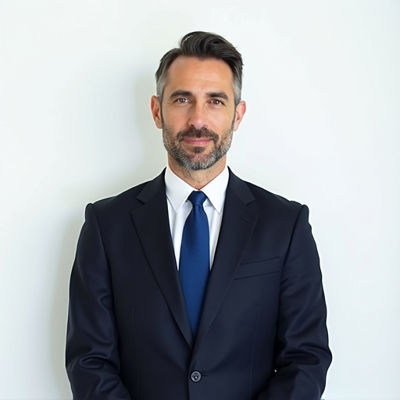

gen_text :   A man is wearing a dark suit with a blue tie and a white shirt. He has short hair and is standing in front of a white background.
gt_text  :   A man in a dark suit and blue tie is standing in front of a white background with the National Board of Review logo.


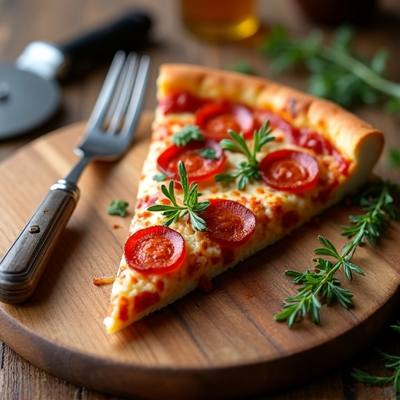

gen_text :   A slice of pizza with pepperoni is on a wooden plate. The pizza has a crispy crust and is topped with a variety of toppings including cheese, vegetables, and herbs. There are two forks on the plate, one on the left side and one on the right side. The plate is on a wooden surface, and there is a bottle of olive oil in the background.
gt_text  :   A slice of pizza with pepperoni and green herbs on a wooden cutting board, accompanied by a fork and a pizza cutter.


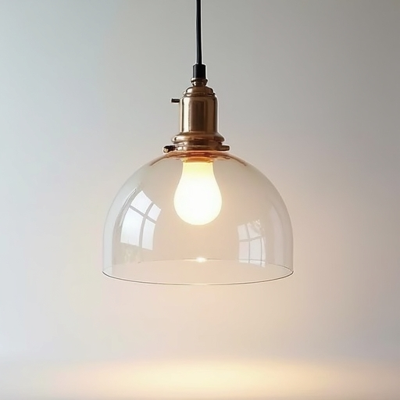

gen_text :   A hanging light fixture with a clear glass shade and a metallic base is illuminated from within, casting a warm glow on the wall behind it.
gt_text  :   A modern glass pendant light with a clear dome-shaped shade and a metallic finish hangs from a white ceiling. The light is turned on, casting a soft glow and creating a warm ambiance.


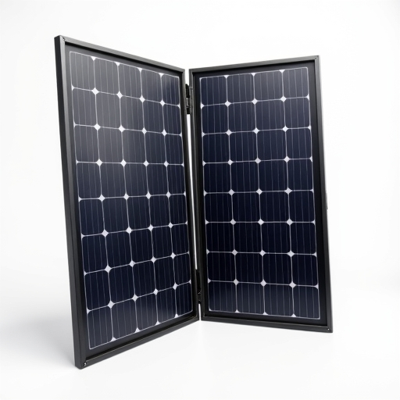

gen_text :   A pair of solar panels is displayed side by side against a white background. The panels are arranged in a way that suggests they are ready for installation or maintenance. The solar panels have a grid pattern with rows and columns of solar cells, and they are encased in a black frame.
gt_text  :   A solar panel with a black frame is open, displaying its photovoltaic cells. The solar panel is placed on a white background.


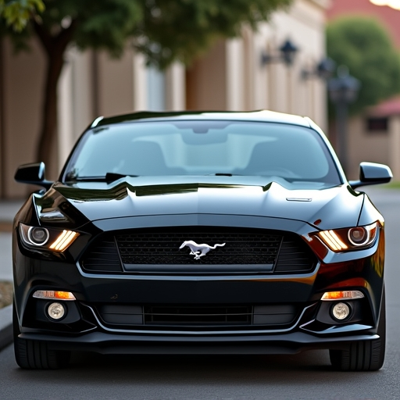

gen_text :   A black car with a shiny surface is parked on a street. The car has a prominent front grille and a black hood with a white emblem. The headlights are on, and the car is positioned in front of a building with a red roof.
gt_text  :   A close-up of the front of a black Ford Mustang with a clear windshield and a visible emblem on the grille. The car is parked in front of a building with a tree and a street lamp visible in the background.


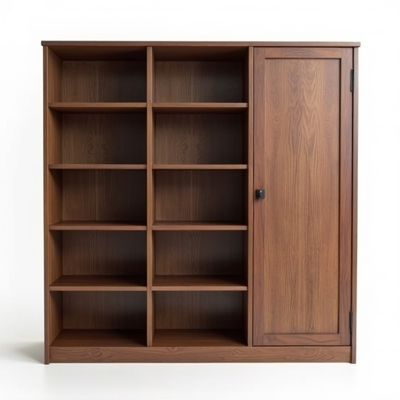

gen_text :   A wooden bookshelf with a brown finish is displayed against a white background. The bookshelf has multiple shelves, with the top shelf containing a small collection of books. The shelves are made of wood and have a simple design. The bookshelf is placed in a way that it appears to be standing upright.
gt_text  :   A wooden bookshelf with a closed door on the right side, featuring five shelves with a total of 15 compartments. The bookshelf has a dark wood finish and is set against a white background.


In [58]:
for img, gt_text in zip(test_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

### 6.2. Train Samples

In [59]:
train_samples = hf_dataset_sampled['train'].shuffle().select(range(6))[:]

In [60]:
gt_texts = [d['prompt'] for d in train_samples['json']]

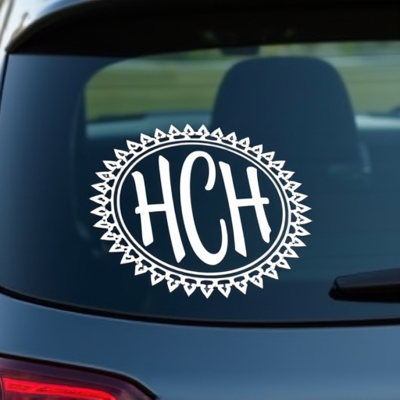

get_text :   A close-up of a car's rear window with a white sticker featuring the letters 'HCH' in a decorative font. The sticker is centered on the window, and the car's license plate is visible in the background.
gt_text  :   A close-up of a car's rear window with a monogram sticker featuring the initials 'HCH' surrounded by a decorative border. The sticker is centered on the window, and the car's interior is visible in the reflection.


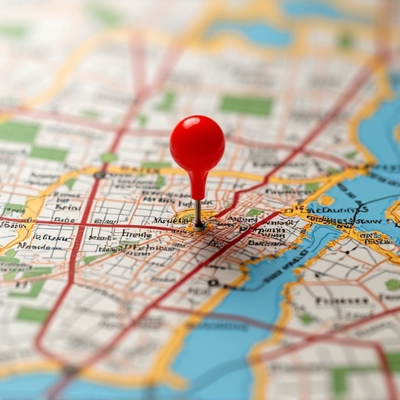

get_text :   A close-up view of a map with a red pin placed on it. The map shows a detailed layout of a city with various streets and landmarks. The red pin is centered on the map, and the pin's tip is pointing towards a specific location on the map. The map has a textured appearance with a yellow border around it.
gt_text  :   A detailed map of a city with various neighborhoods and streets labeled. The map includes a legend with a red pin indicating a specific location, and the map is overlaid with a grid pattern. The map is zoomed in on a specific area, showing the layout of the city and its surrounding areas.


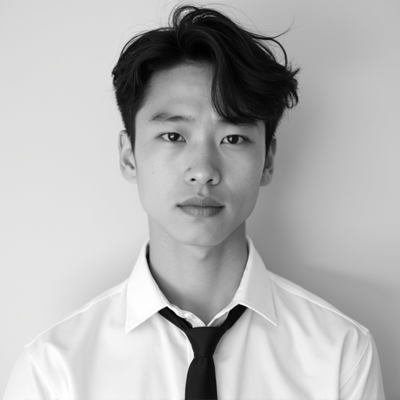

get_text :   A black and white photograph of a young man with short hair, wearing a white shirt with a collar and a tie. He has a neutral expression and is looking directly at the camera. The background is a plain, light color.
gt_text  :   A black and white photograph of a young man with short hair, wearing a white shirt with a collar and a tie. He has a neutral expression and is looking directly at the camera. The background is a plain, light-colored wall.


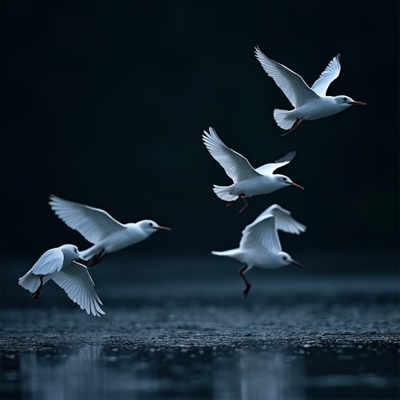

get_text :   A group of white birds is flying in the air, with their wings spread out. The birds are in various stages of flight, with some appearing to be closer to the ground and others flying higher up. The background is a dark, blurred image of a similar scene, possibly a nighttime setting with a focus on the birds.
gt_text  :   A group of white birds is seen in flight at night, with their silhouettes illuminated by a light source from the left. The birds are flying over a wet surface, possibly a body of water, with a dark background that suggests it is nighttime. The birds are in various stages of flight, with some appearing closer to the ground and others higher up.


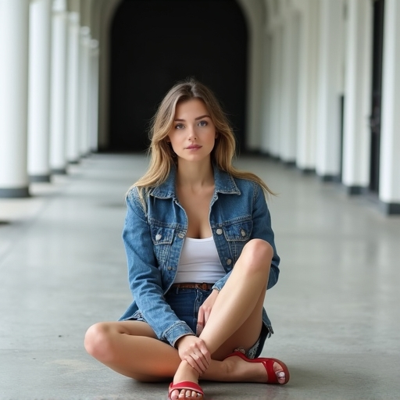

get_text :   A woman is sitting on the floor with her legs crossed, wearing a denim jacket, a white top, and denim shorts. She has long hair and is looking directly at the camera. The setting appears to be a hallway with white columns and a dark background.
gt_text  :   A young woman is sitting on the floor with her legs crossed, wearing a denim jacket, a white top, and denim shorts. She has a red sandal on her left foot and is resting her right hand on her knee. The setting appears to be a corridor with white columns and a black door in the background.


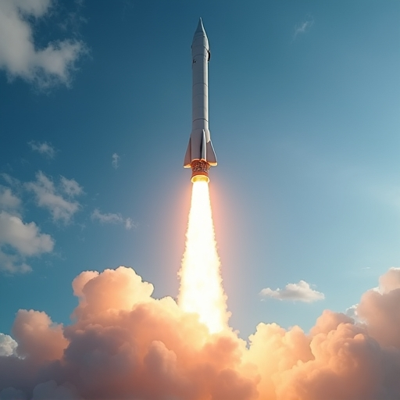

get_text :   A rocket is launched into the sky, with its flames visible and smoke trailing behind. The sky is clear with a few clouds, and the rocket is positioned in the upper right quadrant of the image.
gt_text  :   A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body is elongated and cylindrical, with a pointed tip and a flared base. The sky is dotted with small, round, out-of-focus light spots, possibly from the sun or other light sources.


In [61]:
for img, gt_text in zip(train_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('get_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

In [28]:
llm_model

MultiModalityCausalLM(
  (vision_model): CLIPVisionTower(
    (vision_tower): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear4bit(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Identity()
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): L

In [63]:
del llm_model
del trainer
torch.cuda.empty_cache()

### 6.3. With Initial Model

In [ ]:
llm_model: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    llm_model_path,
    trust_remote_code=True,
    # torch_dtype=llm_dtype,
    torch_dtype='auto',
    quantization_config=bnb_config,
    device_map="auto",
).eval()

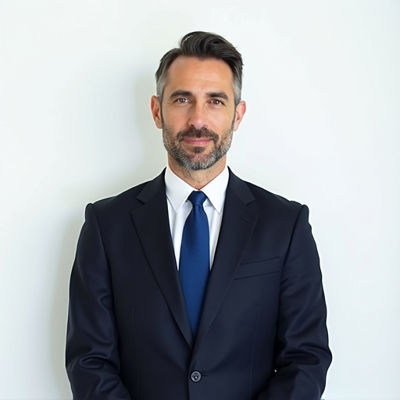

gen_text :  The image shows a person wearing a dark suit with a white shirt and a blue tie. The person is standing against a plain white background. The individual appears to be dressed formally, suitable for professional or business settings.
gt_text  :   A man in a dark suit and blue tie is standing in front of a white background with the National Board of Review logo.


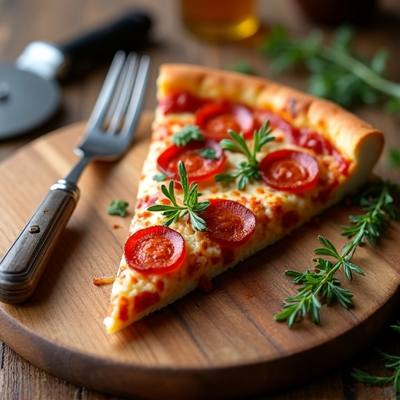

gen_text :  The image shows a slice of pizza on a wooden board. The pizza is topped with pepperoni and garnished with fresh herbs. There is a fork and a pizza cutter placed on the wooden board, ready for use. The background is blurred, focusing attention on the pizza slice.
gt_text  :   A slice of pizza with pepperoni and green herbs on a wooden cutting board, accompanied by a fork and a pizza cutter.


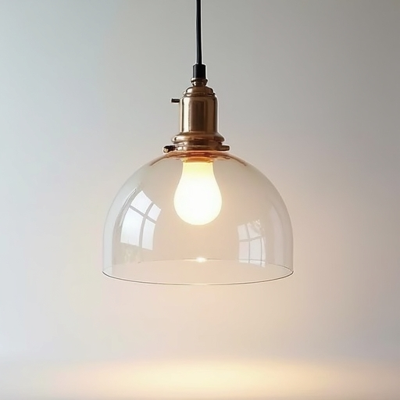

gen_text :  The image shows a pendant light fixture with a clear glass dome shade. The light bulb is visible through the glass, emitting a warm glow. The fixture has a brass or copper-colored base and a black cord for hanging. The background is a plain, light-colored wall, creating a minimalist and modern aesthetic.
gt_text  :   A modern glass pendant light with a clear dome-shaped shade and a metallic finish hangs from a white ceiling. The light is turned on, casting a soft glow and creating a warm ambiance.


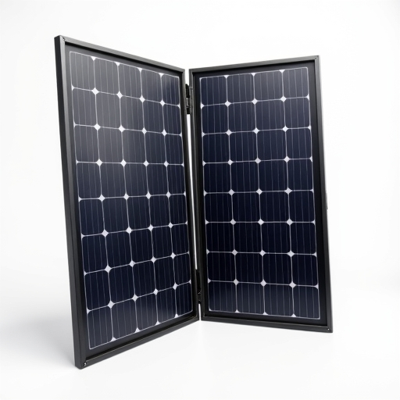

gen_text :  The image shows a solar panel, which is a device that converts sunlight into electricity. The panel consists of multiple solar cells, each made up of a thin layer of photovoltaic material that emits photons when exposed to sunlight. The panel is designed to capture sunlight and convert it into electrical energy, which can then be stored in batteries or used directly to power electronic devices. The solar panel is made up of a frame that holds the cells together, and it is typically used in conjunction with a battery to store the electrical energy generated by the panels.
gt_text  :   A solar panel with a black frame is open, displaying its photovoltaic cells. The solar panel is placed on a white background.


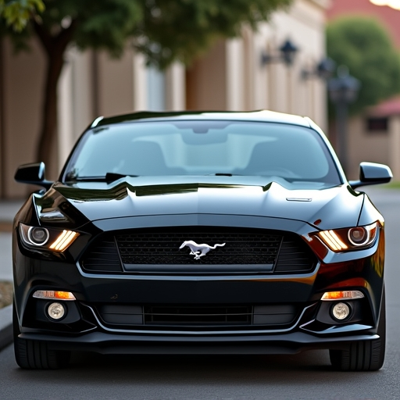

gen_text :  The image shows a sleek black sports car, specifically a Ford Mustang, parked on a street. The car has a shiny, polished exterior with distinctive headlights and fog lights. The front grille features a prominent horse emblem, indicating the model. The background includes blurred buildings and trees, suggesting an urban or suburban setting. The car's design is modern and aerodynamic, emphasizing its sporty and luxurious nature.
gt_text  :   A close-up of the front of a black Ford Mustang with a clear windshield and a visible emblem on the grille. The car is parked in front of a building with a tree and a street lamp visible in the background.


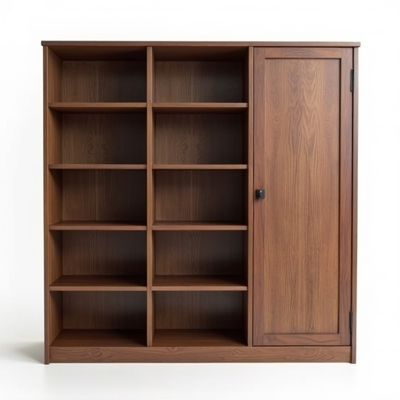

gen_text :  The image shows a wooden bookshelf with a door on the right side. The bookshelf has multiple shelves arranged in a grid pattern, with four shelves on the left side and three on the right side. The wood has a polished finish, giving it a classic and elegant appearance. The door is made of the same material and has a simple black handle. The overall design is clean and minimalistic, suitable for use in a home or office setting.
gt_text  :   A wooden bookshelf with a closed door on the right side, featuring five shelves with a total of 15 compartments. The bookshelf has a dark wood finish and is set against a white background.


In [67]:
for img, gt_text in zip(test_samples['jpg'], [d['prompt'] for d in test_samples['json']]):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

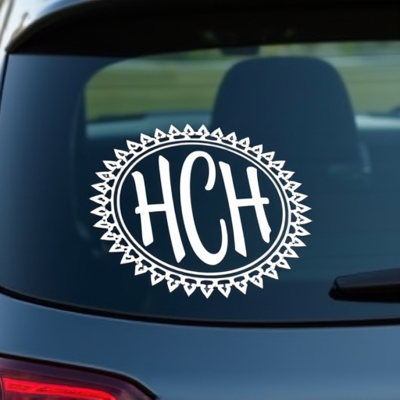

gen_text :  The image shows the rear window of a vehicle, with a decal on the back window. The decal features the letters "HCH" inside an oval shape, surrounded by a decorative border with triangular patterns. The vehicle appears to be dark-colored, and the decal is white, making it stand out against the dark background. The image does not contain any non-English characters.
gt_text  :   A close-up of a car's rear window with a monogram sticker featuring the initials 'HCH' surrounded by a decorative border. The sticker is centered on the window, and the car's interior is visible in the reflection.


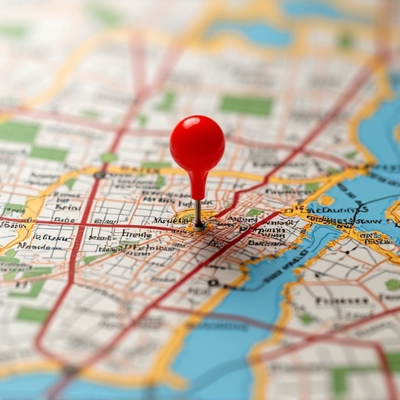

gen_text :  The image shows a close-up of a map with a red pin marking a specific location. The map appears to be a city map, with various streets and landmarks labeled. The red pin is prominently placed on the map, indicating the exact location. The surrounding areas are depicted with different colors, showing the layout of the city. The image does not contain any non-English characters.
gt_text  :   A detailed map of a city with various neighborhoods and streets labeled. The map includes a legend with a red pin indicating a specific location, and the map is overlaid with a grid pattern. The map is zoomed in on a specific area, showing the layout of the city and its surrounding areas.


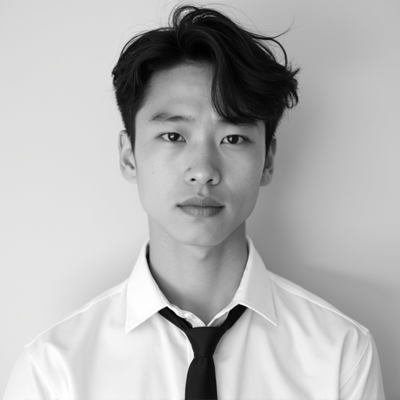

gen_text :  The image shows a person wearing a white dress shirt and a black tie. The person has short, slightly wavy hair and is looking directly at the camera. The image is in black and white, giving it a classic and timeless feel.
gt_text  :   A black and white photograph of a young man with short hair, wearing a white shirt with a collar and a tie. He has a neutral expression and is looking directly at the camera. The background is a plain, light-colored wall.


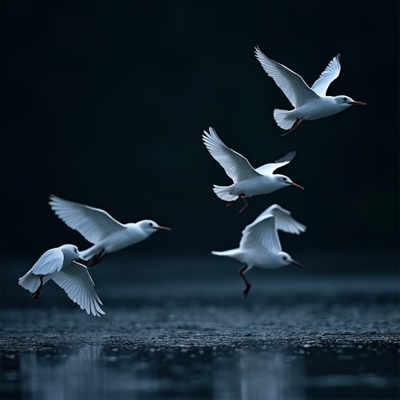

gen_text :  The image depicts a serene and tranquil scene featuring four white birds in flight. The birds are captured mid-flight, with their wings spread wide, creating a sense of motion and freedom. The background is a dark, blurred landscape, which contrasts with the birds, making them stand out prominently. The water below reflects the birds, adding a mirror-like effect to the scene. The overall atmosphere is peaceful and contemplative, evoking a sense of calm and wonder.
gt_text  :   A group of white birds is seen in flight at night, with their silhouettes illuminated by a light source from the left. The birds are flying over a wet surface, possibly a body of water, with a dark background that suggests it is nighttime. The birds are in various stages of flight, with some appearing closer to the ground and others higher up.


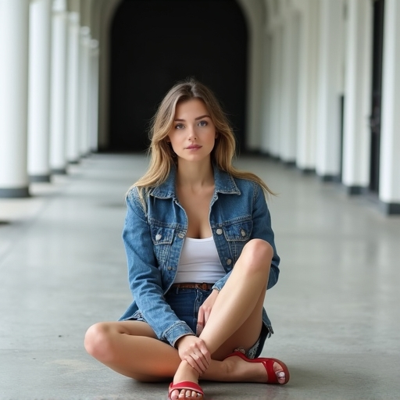

gen_text :  The image shows a young woman sitting on the ground in a hallway. She is wearing a blue denim jacket over a white tank top and denim shorts. Her legs are crossed, and she is wearing red sandals. The hallway has white columns and a dark archway in the background. The woman has long, wavy hair and is looking slightly to the side. The overall setting appears to be a modern, clean, and well-lit area.
gt_text  :   A young woman is sitting on the floor with her legs crossed, wearing a denim jacket, a white top, and denim shorts. She has a red sandal on her left foot and is resting her right hand on her knee. The setting appears to be a corridor with white columns and a black door in the background.


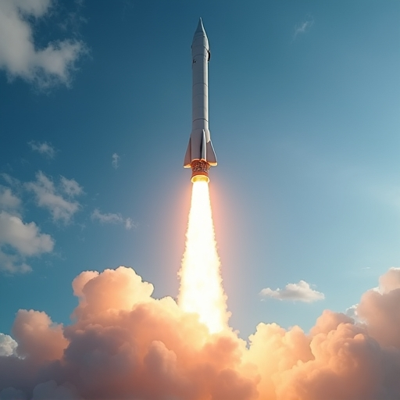

gen_text :  The image depicts a rocket launching into the sky. The rocket is sleek and white, with a pointed top and a visible engine at the bottom, which is emitting bright orange flames and smoke. The sky in the background is a clear blue, with some fluffy clouds beneath the rocket. The overall scene suggests a sense of adventure and exploration.
gt_text  :   A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body is elongated and cylindrical, with a pointed tip and a flared base. The sky is dotted with small, round, out-of-focus light spots, possibly from the sun or other light sources.


In [68]:
for img, gt_text in zip(train_samples['jpg'], [d['prompt'] for d in train_samples['json']]):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)